# Identifying lane markings

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import rectangle, skeletonize
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line

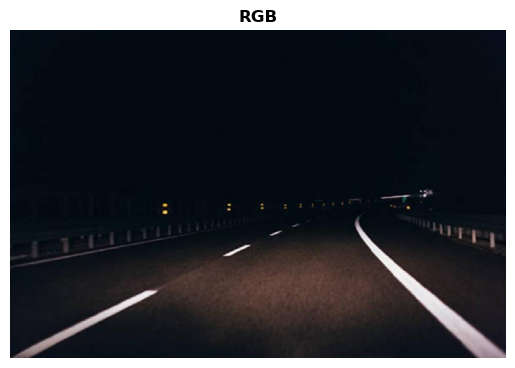

In [2]:
lanes = cv2.imread("./images/lanes.jpg")
lanes = cv2.cvtColor(lanes, cv2.COLOR_BGR2RGB)

plt.imshow(lanes)
plt.title("RGB")
plt.axis('off')
plt.show()

Binarize the image and then remove small regions.

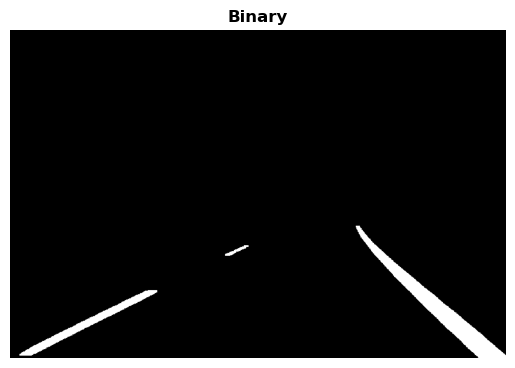

In [3]:
lanes_grayscale = cv2.cvtColor(lanes, cv2.COLOR_RGB2GRAY)
_, lanes_binary = cv2.threshold(lanes_grayscale, 127, 255, cv2.THRESH_OTSU)
lanes_binary = cv2.morphologyEx(lanes_binary, cv2.MORPH_OPEN, rectangle(3, 7))

plt.imshow(lanes_binary, cmap='gray')
plt.title("Binary")
plt.axis('off')
plt.show()

To avoid identifying many lines per lane marking, we can reduce their thickness. This process is known as skeletonization and can be performed with the [skeletonize()](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.skeletonize) function.

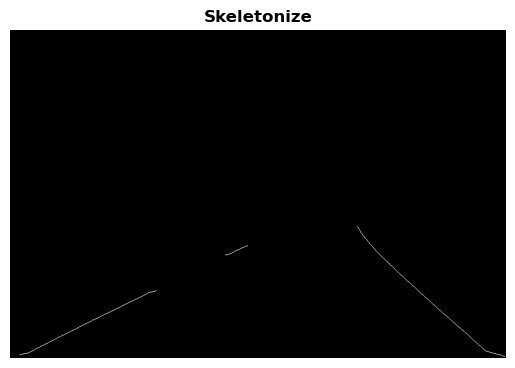

In [4]:
lanes_skeletonize = skeletonize(lanes_binary / 255)

plt.imshow(lanes_skeletonize, cmap='gray')
plt.title("Skeletonize")
plt.axis('off')
plt.show()

We can use the [hough_line()](https://scikit-image.org/docs/stable/api/skimage.transform.html#hough-line) function to compute the Hough transform of a binary image. This is the first of three functions used to identify straight lines.

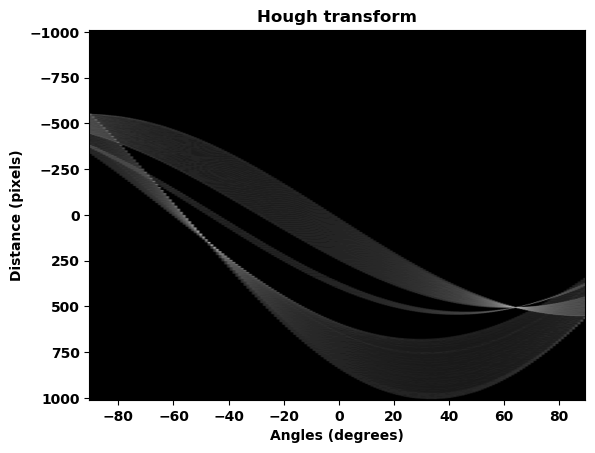

In [5]:
hspace, angles, distance = hough_line(lanes_skeletonize)

angle_step = 0.5 * np.diff(angles).mean()
d_step = 0.5 * np.diff(distance).mean()
bounds = [np.rad2deg(angles[0] - angle_step),
          np.rad2deg(angles[-1] + angle_step),
          distance[-1] + d_step, distance[0] - d_step]
plt.imshow(np.log(1 + hspace), extent=bounds, cmap='gray', aspect='auto')
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.show()

Peaks occur in the hough transform where the sinusoids created by individual pixels cross. We can identify the peaks using [hough_line_peaks()](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks).

In [6]:
peaks = hough_line_peaks(hspace, angles, distance, min_distance=50, num_peaks=10)
print(f"Number of peaks: {len(peaks[0])}")

Number of peaks: 2


We notice that the number of peaks wasn't 10. That's because, with the parameters set, [hough_line_peaks()](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks) only finds prominent peaks. As we can see in the plot of the Hough transform, there are only two prominent peaks.

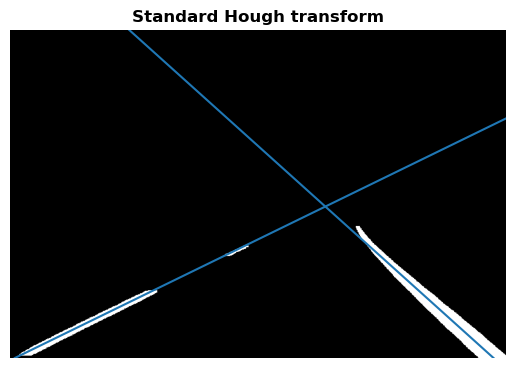

In [7]:
plt.imshow(lanes_binary, cmap='gray')
plt.ylim((lanes_binary.shape[0], 0))
plt.axis('off')
plt.title('Standard Hough transform')

for _, angle, dist in zip(*peaks):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))

We can also use the [probabilistic_hough_line()](https://scikit-image.org/docs/stable/api/skimage.transform.html#probabilistic-hough-line) function,  which returns lines from a progressive probabilistic line Hough transform.

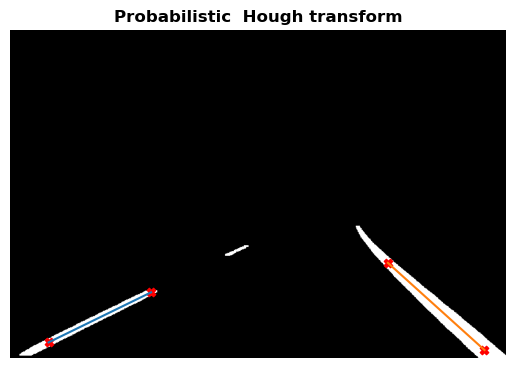

In [11]:
lanes_lines = probabilistic_hough_line(lanes_skeletonize, threshold=10, line_length=150, line_gap=10, seed=0)

plt.imshow(lanes_binary, cmap='gray')
for line in lanes_lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
    plt.scatter((p0[0], p1[0]), (p0[1], p1[1]), marker='X', color='red')
plt.axis('off')
plt.title('Probabilistic  Hough transform')
plt.show()